In [18]:
from matplotlib.pyplot import imshow, figure
from PIL import Image, ImageDraw, ImageFont
from skimage.transform import SimilarityTransform, warp, rotate, rescale
from random import random
import numpy as np
import math

%matplotlib inline

unifont = ImageFont.truetype("fonts/unifont.ttf", 60)
symbols = "A,B,C,D,E".split(',')
sizes = [unifont.getsize(symbol) for symbol in symbols]
max_width = 60
max_height = 60
variations = 5000

print(max_width)
print(max_height)

60
60


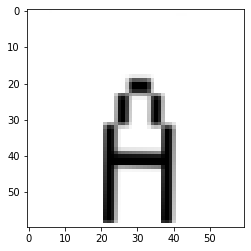

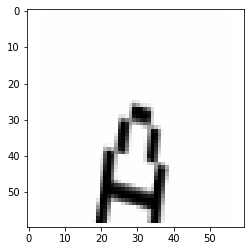

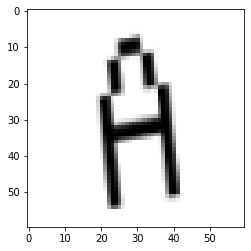

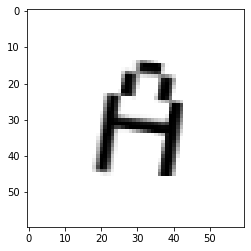

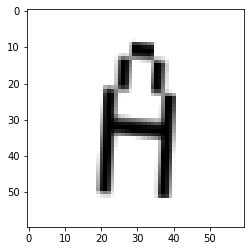

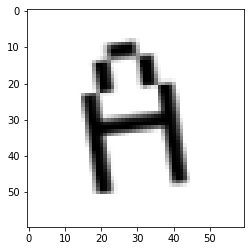

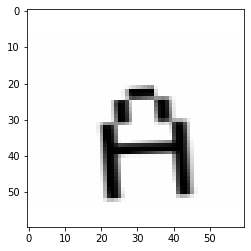

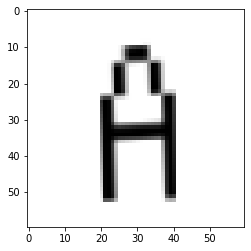

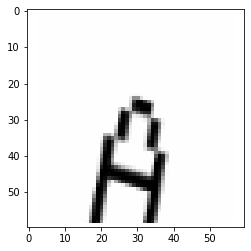

In [19]:
size = len(symbols) * variations
train = np.zeros((size, max_width, max_height), dtype='uint8')
labels = np.empty(size, dtype='object')

for i in range(len(symbols)):
    canvas = Image.new('L', (max_width, max_height), 255)
    draw = ImageDraw.Draw(canvas)
    padding_left = (max_width - sizes[i][0]) / 2
    padding_top = (max_height - sizes[i][1]) / 2
    draw.text((padding_left, padding_top), symbols[i], font = unifont, fill = "#000000")
    for k in range(variations):
        rc = rotate(np.array(canvas), random() * 30 - 15, resize=True, mode='edge', preserve_range=True)
        rc = rescale(np.array(rc), (random() * 0.5 + 0.75, random() * 0.5 + 0.75))
        X, Y = np.array(rc).shape
        begin_found, end_found = False, False
        min_x, min_y = (X, Y)
        max_x, max_y = (0, 0)
        for x in range(X):
            for y in range(Y):
                if rc[x,y] < 255:
                    if x < min_x:
                        min_x = x
                    if x > max_x:
                        max_x = x
                    if y < min_y:
                        min_y = y
                    if y > max_y:
                        max_y = y
        if max_x - min_x > max_width:
            max_x = min_x + max_width - 1
        if max_y - min_y > max_height:
            max_y = min_y + max_height - 1
        c = rc[min_x:max_x, min_y:max_y]
        width = max_x - min_x
        height = max_y - min_y
        h_pad = round((max_width - width) / 2)
        v_pad = round((max_height - height) / 2)
        c = np.pad(c, ((h_pad, max_width - (width + h_pad)),(v_pad, max_height - (height + v_pad))), constant_values = 255)
        train[i * variations + k] = np.array(c)
        labels[i * variations + k] = symbols[i]

for ima in train[3000:3100]:
    figure()
    imshow(ima, cmap='gray')

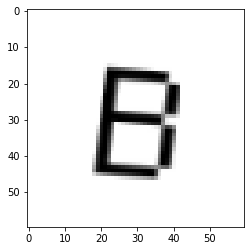

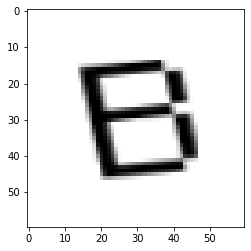

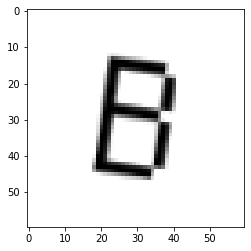

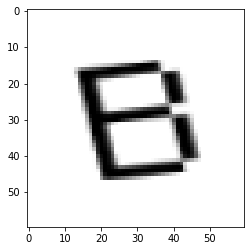

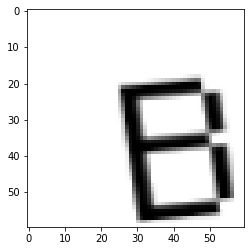

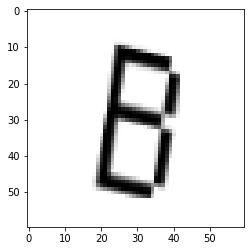

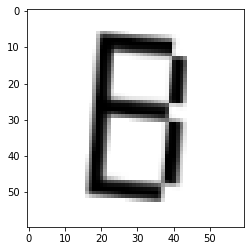

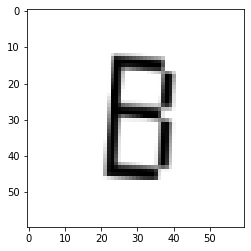

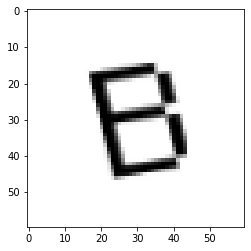

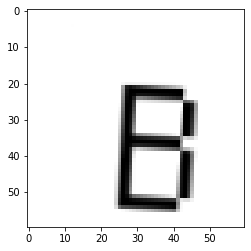

In [34]:
for ima in train[5000:5010]:
    figure()
    imshow(ima, cmap='gray')

['A']
[array([255, 255, 255, ..., 255, 255, 255], dtype=uint8)]


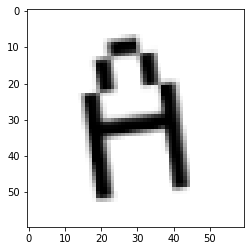

In [21]:
from sklearn.linear_model import SGDClassifier

shuffle_index = np.random.permutation(train.shape[0])
X, y = train[shuffle_index].reshape(train.shape[0], train.shape[1] * train.shape[2]), labels[shuffle_index]

perc_90 = round(X.shape[0] * 0.9)
X_test, X_train, y_test, y_train = X[perc_90:], X[:perc_90], y[perc_90:], y[:perc_90]

y_train_1 = (y_train == symbols[0])

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)

print(sgd_clf.predict([X_train[2]]))
print([X_train[2]])
imshow(X_train[2].reshape(max_width, max_height), cmap="gray")

In [22]:
# pi = np.where(y_train_1)
# X_p = X_train[pi]

# print(sgd_clf.predict([X_p[1]]))
# imshow(X_p[1].reshape(max_width, max_height), cmap="gray")

In [23]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)
confusion_matrix(y_train, y_train_pred)

array([[4485,    2,    0,    4,    7],
       [  11, 4486,    0,   12,   15],
       [   4,    1, 4480,   10,    4],
       [   9,    6,   14, 4432,   12],
       [   6,   37,   25,    2, 4436]])

In [24]:
from sklearn.metrics import precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')


y_scores = cross_val_predict(sgd_clf, X_train, y_train, 
                             cv=3, method='decision_function')

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train, cv=3,
                                   method='predict_proba')
y_scores_forest = y_probas_forest[:,1]

fpr, tpr, thresolds = roc_curve(y_train, y_scores)
fpr_forest, tpr_forest, thresolds_forest = roc_curve(y_train, y_scores_forest)

plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc='lower right')
plt.show()

ValueError: multiclass format is not supported

In [26]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(forest_clf, X_train, y_train, cv=3)
confusion_matrix(y_train, y_train_pred)

array([[4496,    0,    0,    2,    0],
       [   1, 4512,    1,    2,    8],
       [   2,    0, 4494,    3,    0],
       [   2,    1,    5, 4465,    0],
       [   0,    0,    0,    0, 4506]])

In [27]:
# y_test_1 = (y_test == symbols[0]) 
# y_test_pred = cross_val_predict(forest_clf, X_test, y_test_1, cv=3)
# confusion_matrix(y_test_1, y_test_pred)

In [29]:
import pickle

forest_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [30]:
clf_filename = 'forest_clf_1.pkl'
clf_file = open(clf_filename, 'wb')
pickle.dump(forest_clf, clf_file, protocol=2, fix_imports=True)
clf_file.close()

In [31]:
clf_file = open(clf_filename,'rb')
model = pickle.load(clf_file)

In [32]:
model

RandomForestClassifier(random_state=42)